In [8]:
### MAKING FIGURE WITH SPECTRA

import numpy as np
from scipy.interpolate import splrep, splev, splint
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import numpy as np
from numpy import *
from collections import Counter
from scipy import interpolate
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
import sys
import os
import pylab
from matplotlib import rc
from matplotlib.colors import LogNorm
import scipy
import scipy.integrate
from scipy.optimize import curve_fit
import seaborn as sns


cte_c_kms=2.99792458e5 ## km s-1




### Parameters for the AGN SED
nu_IR=0.01*3.2899*1e15 #0.01 Ryd to Hz
alpha_UV=-0.5
alpha_x=-1.0

# taken from Table1 of Thomas+16 paper
Ax2=-0.18
Ax1=0.0
Ax0=0.59
B=0.250
b3x1=0.034
b3x0=-0.019

b1x2=0.391
b1x1=-0.83
b1x0=0.61
ax2=-0.3
ax1=0.4
ax0=-0.82


def S(L_BH, M_BH):
  # M_BH in Msun
  # L_BH/L_Edd the Eddington ratio
  # Here our L is in real units.
  #L_Edd = M_BH*4.*np.pi*cte_G*cte_m_p*cte_c/cte_sigma_t
  L_Edd = 1.26*1e38 * M_BH # in erg/s
  S     = np.log10((L_BH/L_Edd)/M_BH)
  #     = np.log10((L_BH)/M_BH)
  return S

def R(r_corona, M_BH):
  # r_corona the coronal radius (inner edge of the visible portion of the disk). Should be in units of r_g
  # r_g the gravitational radius, r_g = cte_G*M_BH/cte_c**2
  #r_g   = cte_G*M_BH/cte_c**2
  #R     = np.log10(r_corona/r_g)
  R = np.log10(r_corona)
  return R

def f1(L_BH, M_BH, r_corona):
  f1    = Ax2*R(r_corona, M_BH)*R(r_corona, M_BH) + Ax1*R(r_corona, M_BH) + Ax0 + B*S(L_BH,M_BH)
  return f1

def f2(L_BH, M_BH, r_corona):
  #print(R(r_corona, M_BH))
  #print(S(L_BH,M_BH))
  #print(L_BH,M_BH,r_corona)
  #print('ho')
  f2    = (b3x1*R(r_corona, M_BH)+b3x0)*np.power(S(L_BH,M_BH)+6,3) + (b1x2*R(r_corona, M_BH)*R(r_corona, M_BH) + b1x1*R(r_corona, M_BH) + b1x0)*(S(L_BH, M_BH)+6) + (ax2*R(r_corona, M_BH)*R(r_corona, M_BH) + ax1*R(r_corona, M_BH) + ax0)
  return f2

def log10_E_peak(L_BH,M_BH,r_corona):
  # E_peak used to parametrize both the location in energy space and the shape of the Big Blue Bump of the disk emission.
  # E_peak in keV according to Thomas
  #rint('ours',f1(L_BH, M_BH, r_corona),f2(L_BH, M_BH, r_corona))
  log10_E_peak = max(f1(L_BH, M_BH, r_corona),f2(L_BH, M_BH, r_corona))
  return log10_E_peak


def alpha_ox(L_BH,M_BH):
  L_Edd     = 1.26*10**38*M_BH # in erg/s
  alpha_ox  =  -0.13*np.log(M_BH)+0.15*np.log10(L_BH/L_Edd)-0.45
  return alpha_ox

def F_nu(nu,L_BH,M_BH,r_corona):
  #This line is meant to convert from E_peak in kev to nu_peak in Hz
  #print(log10_E_peak(L_BH,M_BH,r_corona))
  numax_peak = 2.417e17*(10**log10_E_peak(L_BH,M_BH,r_corona))    # in Hz

  nu1=4.8359e17 # in Hz?
  nu2=1.1992e15 # in Hz?

  param = (nu1**(alpha_UV) * np.exp(-nu1/numax_peak) * np.exp(-nu_IR/nu1)-
           10**(alpha_ox(L_BH,M_BH)*2.6056) * nu2**alpha_UV * np.exp(-nu2/numax_peak)*
           exp(-nu_IR/nu2))/(10**(alpha_ox(L_BH,M_BH)*2.6056) * nu2**
                             alpha_x - nu1**alpha_x)
  if param < 0:
    param = (10**(alpha_ox(L_BH,M_BH)*2.6056) * nu2**alpha_UV * exp(-nu2/numax_peak)*
             exp(-nu_IR /nu2))/(nu1**alpha_x)


  #PARAM = 0. ## set to 0 for now.
  PARAM = param
  #rint('numax_peak=',numax_peak)
  #print('factor Fnu,',np.exp(-nu / numax_peak), np.exp(-nu_IR / nu) )

  F_nu  = nu**alpha_UV * np.exp(-nu / numax_peak) * np.exp(-nu_IR / nu)  + PARAM*nu**alpha_x
  ##F_nu[np.where(nu<(0.1*3.2899e15))[0]] = nu[np.where(nu<(0.1*3.2899e15))[0]]**alpha_UV * np.exp(-nu[np.where(nu<(0.1*3.2899e15))[0]] / numax_peak) * np.exp(-nu_IR / nu[np.where(nu<(0.1*3.2899e15))[0]])
  for ii in range(len(nu)):
    if nu[ii]<3.2899e14: ### last term of Eq set to zero below 1.36 eV = 912 nm
      #print('nu= ',nu[ii],3.2899e14)
      F_nu[ii]  = nu[ii]**alpha_UV * np.exp(-nu[ii] / numax_peak) * np.exp(-nu_IR / nu[ii])
  return F_nu

def F_lambda(F_nu,nu):
  # from F_nu to F_lambda
  #from (erg/s/cm^2/Hz) to (erg/s/cm^2/A)
  F_lambda = F_nu*(3e18)/((3e18/nu)**2)
  return F_lambda


def make_spectrum_AGN(wavelength,bh_mass,bh_lum):

    L_BH  = 10**bh_lum # in erg/s
    M_BH  = bh_mass # in Msun
    L_Edd = 1.26*10**38*M_BH # in erg/s
    f_Edd_1 = np.log10(L_BH/L_Edd)

    nu = np.divide(3e18,wavelength) # from AA to Hz
    r_corona = 10.
    to_print_F_nu=F_nu(nu,L_BH,M_BH,r_corona)
    nu_peak = 10**(log10_E_peak(L_BH,M_BH,r_corona))*2.42e17
    ## normalization
    norm_1=(L_BH)/scipy.integrate.quadrature(F_nu,nu_peak*1e-3,nu_peak*1e3,args=(L_BH,M_BH,r_corona))[0]
    return(F_lambda(norm_1*to_print_F_nu, nu))






In [2]:
names_elines=['OII',' Hbeta','OIII','OIII','OI','NII','Halpha','NII','SII','SII','NV1240 CIV1548 CIV1551 HeII1640 OIII','OIII','SiIII','SiIII','CIII','CIII']
names_elines=['OII',' Hbeta','OIII','OIII','OI','NII','Halpha','NII','SII','SII','NV1240,etc.','OIII','SiIII','SiIII','CIII','CIII']

elines=[3727,4861,4959,5007,6300,6548,6563,6584,6717,6731,1661,1666,1883,1888,1907,1910]


c:\Users\clara\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.582739e+06
  AccuracyWarning)
c:\Users\clara\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.082945e+05
  AccuracyWarning)
c:\Users\clara\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.780634e+06
  AccuracyWarning)
c:\Users\clara\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.851840e+05
  AccuracyWarning)
c:\Users\clara\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.225878e+06
  AccuracyWarning)


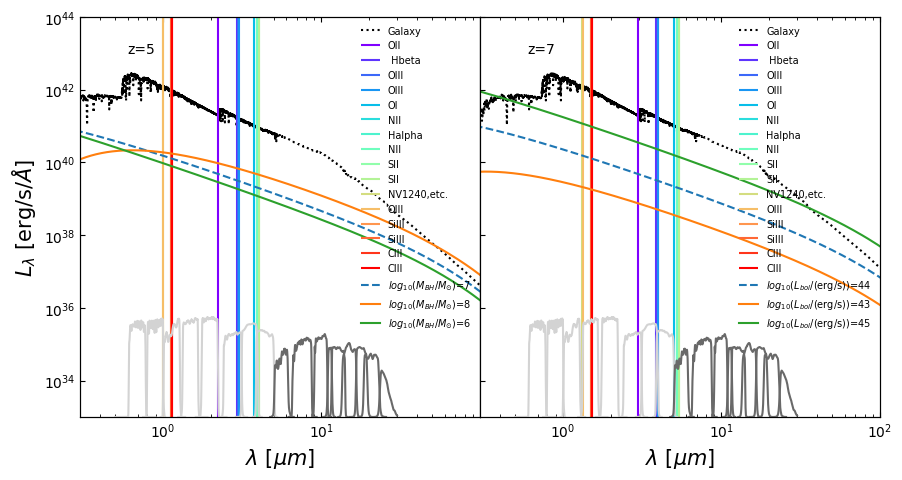

In [3]:
library = pd.read_csv('TNG_50_library/library_galaxies_with_BH.txt',header=None,
                    names=['galaxy number','age end SFR','Mstar end SFR','BH mass','BH Lum'])
import matplotlib as mtp
mtp.rcParams['figure.figsize']=[20,10]
fig=plt.figure()
gs1=gridspec.GridSpec(1,2)
gs1.update(left=0.1,right=0.5, bottom=0.2, top=0.6, hspace=0.3, wspace=0.0)

z = 5
galaxy_num = library['galaxy number'].to_numpy()
i = 1

age_gal = library['age end SFR'][library['galaxy number']==i]
age_gal_i = int(age_gal.to_numpy()[0])
age_gal_i = round(age_gal_i*1e-9,3)

cm = plt.cm.get_cmap('rainbow')
X = np.arange(16)
x_span = X.max()-X.min()
color1 = [cm(((x-X.min())/x_span)) for x in X]



df = pd.read_csv('TNG_50_library/TNG50_out_17_gal_'+str(i)+'_age=0'+str(age_gal_i)+'.sed', header=None, skiprows=6)
df = df[0].str.split(expand=True)
#distance modulus at z = 8
mu = 49.53
wavelength = df[0].astype('float64').to_numpy()
#wavelength = df[0].to_numpy()
flux = df[1].astype('float64').to_numpy()
#print(wavelength,flux)
#print(wavelength.astype(np.float))
flux = 3.826e+33*flux
AGN = make_spectrum_AGN(wavelength, 1e7,44)
#print(wavelength)
ax=plt.subplot(gs1[0])
ax.tick_params(axis='both',which='both',direction='in',bottom=True,top=True,left=True,right=True)
ax.tick_params(right=False, labelright=False)

#ax.loglog(wavelength,flux,label='Galaxy '+str(i))
#ax.loglog(wavelength,AGN,label='AGN BH Luminosity 10**'+str(mm))
ax.loglog(np.multiply(wavelength,0.0001*(1+z)),flux,label='Galaxy', linestyle='dotted', color='black')
for x in np.arange(len(elines)):
    ax.vlines(np.multiply(elines[x],0.0001*(1+z)),1e30,1e50,label=names_elines[x],colors=color1[x])
ax.loglog(wavelength*0.0001*(1+z),AGN,label=r'$log_{10}(M_{BH}/M_{\odot})$=7', linestyle='dashed')
AGN = make_spectrum_AGN(wavelength, 1e8,44)
ax.loglog(wavelength*0.0001*(1+z),AGN,label=r'$log_{10}(M_{BH}/M_{\odot})$=8')
AGN = make_spectrum_AGN(wavelength, 1e6,44)
ax.loglog(wavelength*0.0001*(1+z),AGN,label=r'$log_{10}(M_{BH}/M_{\odot})$=6')
ax.set_ylim(1e33,1e44)
ax.set_xlim(3e-1,1e2)
ax.set_xlabel(r'$\lambda$ $[\mu m]$',fontsize=15)
ax.set_ylabel(r'$L_{\lambda}$ [erg/s/$\AA$]',fontsize=15)
ax.legend(frameon=False,fontsize=7,loc='upper right')
ax.text(6e-1,1e43,'z=5')
labels = ax.get_xticks()
ax.set_xticks(ticks = labels[2:-2])



AX2 = ax.twinx()
ff = ['F070','F090','F115','F150','F200','F277','F356','F444']
for f in ff:
    df = pd.read_csv('Filter/'+str(f)+'W_JWST_NIRCAM.txt', delimiter= '\s+', skiprows=(1),names=['Wavelength','filter'])
    AX2.plot(df['Wavelength'].to_numpy()*0.0001, df['filter'].to_numpy()*0.5, label='F115W',color='lightgray')
ff = ['F0560','F0770','F1000','F1130','F1280','F1500','F1800','F2100','F2550']
for f in ff:
    df = pd.read_csv('Filter/'+str(f)+'W_JWST_MIRI.txt', delimiter= '\s+', skiprows=(1),names=['Wavelength','filter'])
    AX2.plot(df['Wavelength'].to_numpy()*0.0001, df['filter'].to_numpy(), label='F115W',color='dimgrey')
AX2.set_ylim([0,2])
AX2.tick_params(bottom=False, labelbottom=False, right=False, labelright=False)


ax=plt.subplot(gs1[1])
ax.tick_params(axis='both',which='both',direction='in',bottom=True,top=True,left=True,right=True)
ax.tick_params(left=False, labelleft=False)
z=7

AGN = make_spectrum_AGN(wavelength, 1e7,44)
#ax.loglog(wavelength,flux,label='Galaxy '+str(i))
#ax.loglog(wavelength,AGN,label='AGN BH Luminosity 10**'+str(mm)
ax.loglog(wavelength*0.0001*(1+z),flux,label='Galaxy', linestyle='dotted', color='black')
for x in np.arange(len(elines)):
    ax.vlines(np.multiply(elines[x],0.0001*(1+z)),1e30,1e50,label=names_elines[x],colors=color1[x])

ax.loglog(wavelength*0.0001*(1+z),AGN,label=r'$log_{10}(L_{bol}$/(erg/s))=44', linestyle='dashed')
AGN = make_spectrum_AGN(wavelength, 1e7,43)
ax.loglog(wavelength*0.0001*(1+z),AGN,label=r'$log_{10}(L_{bol}$/(erg/s))=43')
AGN = make_spectrum_AGN(wavelength, 1e7,45)
ax.loglog(wavelength*0.0001*(1+z),AGN,label=r'$log_{10}(L_{bol}$/(erg/s))=45')
ax.set_ylim(1e33,1e44)
ax.set_xlim(3e-1,1e2)
ax.set_xlabel(r'$\lambda$ $[\mu m]$',fontsize=15)
#ax.set_ylabel(r'$L_{\lambda}$ in erg/s/$\AA$')
labels = ax.get_xticks()
ax.set_xticks(ticks = labels[2:-1])
ax.text(6e-1,1e43,'z=7')
ax.legend(frameon=False,fontsize=7,loc='upper right')

AX2 = ax.twinx()
ff = ['F070','F090','F115','F150','F200','F277','F356','F444']
for f in ff:
    df = pd.read_csv('Filter/'+str(f)+'W_JWST_NIRCAM.txt', delimiter= '\s+', skiprows=(1),names=['Wavelength','filter'])
    AX2.plot(df['Wavelength'].to_numpy()*0.0001, df['filter'].to_numpy()*0.5, label='F115W',color='lightgray')
ff = ['F0560','F0770','F1000','F1130','F1280','F1500','F1800','F2100','F2550']
for f in ff:
    df = pd.read_csv('Filter/'+str(f)+'W_JWST_MIRI.txt', delimiter= '\s+', skiprows=(1),names=['Wavelength','filter'])
    AX2.plot(df['Wavelength'].to_numpy()*0.0001, df['filter'].to_numpy(), label='F115W',color='dimgrey')
AX2.set_ylim([0,2])
AX2.tick_params(bottom=False, labelbottom=False, right=False, labelright=False)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


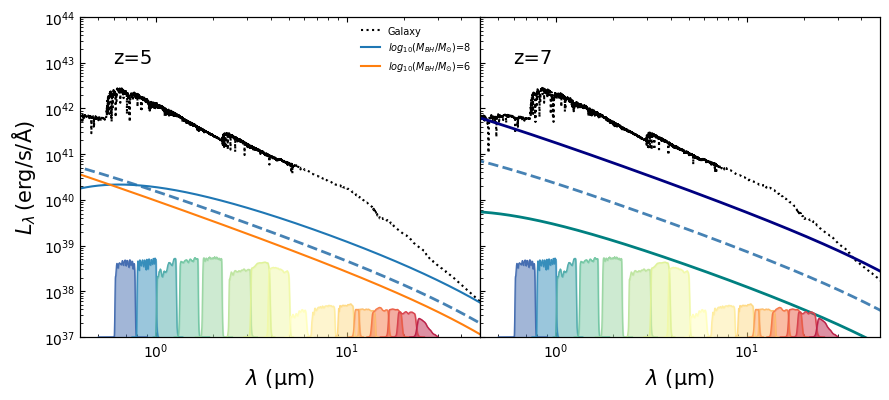

In [4]:
## MELANIE's VERSION

library = pd.read_csv('TNG_50_library/library_galaxies_with_BH.txt',header=None,
                    names=['galaxy number','age end SFR','Mstar end SFR','BH mass','BH Lum'])


ff=['F070','F090','F115','F150','F200','F277','F356','F444','F0560','F0770','F1000','F1130','F1280','F1500','F1800','F2100','F2550']
#color_filters=['blueviolet','mediumpurple','blue','royalblue','steelblue','dodgerblue','deepskyblue','mediumturquoise','teal','seagreen','mediumseagreen','lightgreen','palegreen','peachpuff','lightsalmon','lightcoral','indianred']
color_filters = sns.color_palette("Spectral_r", 17)

ylim=[1e37,1e44]
xlim=[4e-1,5e1]#[4e-1,6e2]
mtp.rcParams['figure.figsize']=[20,8]
fig=plt.figure()
gs1=gridspec.GridSpec(1,2)
gs1.update(left=0.1,right=0.5, bottom=0.2, top=0.6, hspace=0.3, wspace=0.0)

z = 5
galaxy_num = library['galaxy number'].to_numpy()
i = 1

age_gal = library['age end SFR'][library['galaxy number']==i]
age_gal_i = int(age_gal.to_numpy()[0])
age_gal_i = round(age_gal_i*1e-9,3)

cm = plt.cm.get_cmap('rainbow')
X = np.arange(16)
x_span = X.max()-X.min()
color1 = [cm(((x-X.min())/x_span)) for x in X]



df = pd.read_csv('TNG_50_library/TNG50_out_17_gal_'+str(i)+'_age=0'+str(age_gal_i)+'.sed', header=None, skiprows=6)
df = df[0].str.split(expand=True)
#distance modulus at z = 8
mu = 49.53
wavelength = df[0].astype('float64').to_numpy()
#wavelength = df[0].to_numpy()
flux = df[1].astype('float64').to_numpy()
#print(wavelength,flux)
#print(wavelength.astype(np.float))
flux = 3.826e+33*flux

#print(wavelength)
ax=plt.subplot(gs1[0])
ax.tick_params(axis='both',which='both',direction='in',bottom=True,top=True,left=True,right=True)
ax.tick_params(right=False, labelright=False)

#ax.loglog(wavelength,flux,label='Galaxy '+str(i))
#ax.loglog(wavelength,AGN,label='AGN BH Luminosity 10**'+str(mm))
ax.loglog(np.multiply(wavelength,0.0001*(1+z)),flux,label='Galaxy', linestyle='dotted', color='black')
###for x in np.arange(len(elines)):
###    ax.vlines(np.multiply(elines[x],0.0001*(1+z)),1e30,1e50,label=names_elines[x],colors=color1[x])

AGN = make_spectrum_AGN(wavelength, 1e7,44)
ax.loglog(wavelength*0.0001*(1+z),AGN,color='steelblue',lw=2, linestyle='dashed')#label=r'$log_{10}(M_{BH}/M_{\odot})$=7', linestyle='dashed')

AGN = make_spectrum_AGN(wavelength, 1e8,44)
ax.loglog(wavelength*0.0001*(1+z),AGN,label=r'$log_{10}(M_{BH}/M_{\odot})$=8')

AGN = make_spectrum_AGN(wavelength, 1e6,44)
ax.loglog(wavelength*0.0001*(1+z),AGN,label=r'$log_{10}(M_{BH}/M_{\odot})$=6')

ax.set_ylim(ylim[0],ylim[1])
ax.set_xlim(xlim[0],xlim[1])
ax.set_xlabel(r'$\lambda$ $(\rm \mu m)$',fontsize=15)
ax.set_ylabel(r'$L_{\lambda} \, \rm (erg/s/\AA)$',fontsize=15)
ax.legend(frameon=False,fontsize=7,loc='upper right')
ax.text(6e-1,1e43,'z=5',fontsize=14)
labels = ax.get_xticks()
ax.set_xticks(ticks = labels[2:-2])

AX2 = ax.twinx()
for f in range(len(ff)):
    if f<8:
      df = pd.read_csv('Filter/'+str(ff[f])+'W_JWST_NIRCAM.txt', delimiter= '\s+', skiprows=(1),names=['Wavelength','filter'])
    else:
      df = pd.read_csv('Filter/'+str(ff[f])+'W_JWST_MIRI.txt', delimiter= '\s+', skiprows=(1),names=['Wavelength','filter'])

    AX2.plot(df['Wavelength'].to_numpy()*0.0001, df['filter'].to_numpy()*0.5,lw=1,color=color_filters[f])
    AX2.fill_between(df['Wavelength'].to_numpy()*0.0001,[0]*len(df['filter']), df['filter'].to_numpy()*0.5,alpha=0.5,color=color_filters[f])

AX2.set_ylim([0,2])
AX2.tick_params(bottom=False, labelbottom=False, right=False, labelright=False)




### PANEL 2
ax=plt.subplot(gs1[1])
ax.tick_params(axis='both',which='both',direction='in',bottom=True,top=True,left=True,right=True)
ax.tick_params(left=False, labelleft=False)
z=7


ax.loglog(wavelength*0.0001*(1+z),flux, linestyle='dotted', color='black')
###for x in np.arange(len(elines)):
###    ax.vlines(np.multiply(elines[x],0.0001*(1+z)),1e30,1e50,label=names_elines[x],colors=color1[x])
AGN = make_spectrum_AGN(wavelength, 1e7,44)
ax.loglog(wavelength*0.0001*(1+z),AGN,color='steelblue',lw=2,linestyle='dashed')#label=r'$log_{10}(L_{bol}$/(erg/s))=44', linestyle='dashed')

AGN = make_spectrum_AGN(wavelength, 1e7,43)
ax.loglog(wavelength*0.0001*(1+z),AGN,color='teal',lw=2)#label=r'$log_{10}(L_{bol}$/(erg/s))=43')

AGN = make_spectrum_AGN(wavelength, 1e7,45)
ax.loglog(wavelength*0.0001*(1+z),AGN,color='navy',lw=2)#,label=r'$log_{10}(L_{bol}$/(erg/s))=45')

ax.set_ylim(ylim[0],ylim[1])
ax.set_xlim(xlim[0],xlim[1])
ax.set_xlabel(r'$\lambda$ $(\rm \mu m)$',fontsize=15)
ax.text(6e-1,1e43,'z=7',fontsize=14)
ax.legend(frameon=False,fontsize=7,loc='upper right')

AX2 = ax.twinx()
for f in range(len(ff)):
    if f<8:
      df = pd.read_csv('Filter/'+str(ff[f])+'W_JWST_NIRCAM.txt', delimiter= '\s+', skiprows=(1),names=['Wavelength','filter'])
    else:
      df = pd.read_csv('Filter/'+str(ff[f])+'W_JWST_MIRI.txt', delimiter= '\s+', skiprows=(1),names=['Wavelength','filter'])

    AX2.plot(df['Wavelength'].to_numpy()*0.0001, df['filter'].to_numpy()*0.5,lw=1,color=color_filters[f])
    AX2.fill_between(df['Wavelength'].to_numpy()*0.0001,[0]*len(df['filter']), df['filter'].to_numpy()*0.5,alpha=0.5,color=color_filters[f])
AX2.set_ylim([0,2])
AX2.tick_params(bottom=False, labelbottom=False, right=False, labelright=False)
plt.savefig('example_spectra_and_filters.pdf',transparent=True)

2.2362 2.2360800000000003 2.34790142e+41
2.9166000000000003 2.9164800000000004 1.025249394e+41
2.9754 2.97534 1.683577736e+41
3.0042 3.0039600000000006 1.598456888e+41
3.9378 3.93762 5.90512492e+40
3.9504 3.9505800000000004 9.17046288e+40
4.030200000000001 4.02996 8.55539512e+40
4.038600000000001 4.038600000000001 8.87142272e+40
0.744 0.744 2.0623632140000002e+42
0.9288000000000001 0.9288000000000001 9.056792420000001e+41
0.9306000000000001 0.9306000000000001 8.88599978e+41
0.984 0.984 1.044092444e+42
0.9965999999999999 0.9965999999999999 1.230257952e+42
0.9996 0.9996 1.288707754e+42
1.1298 1.1298 8.73640318e+41
1.1328 1.1328 8.65487112e+41
1.1442 1.1442 8.30322346e+41
1.146 1.146 8.61817978e+41


c:\Users\clara\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.780634e+06
  AccuracyWarning)
c:\Users\clara\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.435652e+06
  AccuracyWarning)
c:\Users\clara\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.226038e+06
  AccuracyWarning)
c:\Users\clara\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.582739e+06
  AccuracyWarning)
c:\Users\clara\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\integrate\_quadrature.py:278: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.225878e+06
  AccuracyWarning)


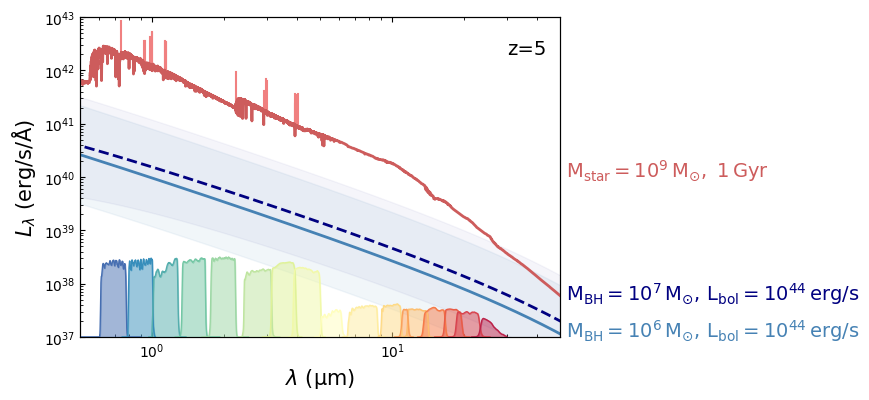

In [5]:
## MELANIE's VERSION

library = pd.read_csv('TNG_50_library/library_galaxies_with_BH.txt',header=None,
                    names=['galaxy number','age end SFR','Mstar end SFR','BH mass','BH Lum'])


ff=['F070','F090','F115','F150','F200','F277','F356','F444','F0560','F0770','F1000','F1130','F1280','F1500','F1800','F2100','F2550']
color_filters = sns.color_palette("Spectral_r", 17)

ylim=[1e37,1e43]
xlim=[5e-1,5e1]#[4e-1,6e2]
mtp.rcParams['figure.figsize']=[12,8]
fig=plt.figure()
gs1=gridspec.GridSpec(1,1)
gs1.update(left=0.1,right=0.5, bottom=0.2, top=0.6, hspace=0.3, wspace=0.0)

z = 5
galaxy_num = library['galaxy number'].to_numpy()
i = 1

age_gal = library['age end SFR'][library['galaxy number']==i]
age_gal_i = int(age_gal.to_numpy()[0])
age_gal_i = round(age_gal_i*1e-9,3) # Mel: ??

cm = plt.cm.get_cmap('rainbow')
X = np.arange(16)
x_span = X.max()-X.min()
color1 = [cm(((x-X.min())/x_span)) for x in X]



df = pd.read_csv('TNG_50_library/TNG50_out_17_gal_'+str(i)+'_age=0'+str(age_gal_i)+'.sed', header=None, skiprows=6)
df = df[0].str.split(expand=True)
#distance modulus at z = 8
mu = 49.53 ## Mel: ??
wavelength = df[0].astype('float64').to_numpy()
flux = df[1].astype('float64').to_numpy()
flux = 3.826e+33*flux


ax=plt.subplot(gs1[0])
ax.tick_params(axis='both',which='both',direction='in',bottom=True,top=True,left=True,right=True)
ax.tick_params(right=False, labelright=False)

### GALAXY
ax.loglog(np.multiply(wavelength,0.0001*(1+z)),flux, lw=2,color='indianred',zorder=12)
#plt.text(6*1e0,1e40,r'$\rm M_{star}=10^{9}\, M_{\odot}, \, \,1 \, Gyr $',rotation=-20,fontsize=14, color='indianred')
plt.text(xlim[1]+3.,1e40,r'$\rm M_{star}=10^{9}\, M_{\odot}, \, \,1 \, Gyr $',fontsize=14, color='indianred')

### NEBULAR EMISSION LINES
# Z=0.008 (metallicity of the gas taken half solar)
logUs, xid, nh, rat, m_UV, line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910 =np.loadtxt('Emission_lines/nebular_emission_Z008.txt',skiprows=1,unpack=True)
line_name=[line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910]
line_wavelength=[3727,4861,4959,5007,6563,6584,6717,6731,1240,1548,1551,1640,1661,1666,1883,1888,1907,1910]
line_wavelength=[pp*0.0001*(1+z) for pp in line_wavelength]
line_height=[line_name[pp][0]*1e45/1e45 for pp in range(len(line_wavelength))]

index_flux=[0.]*len(line_wavelength)
for ppp in range(len(line_wavelength)):
  difference_array = np.absolute(wavelength*0.0001*(1+z)-line_wavelength[ppp])
  index_flux[ppp]=flux[difference_array.argmin()]
  print(line_wavelength[ppp],wavelength[difference_array.argmin()]*0.0001*(1+z),flux[difference_array.argmin()])

for pp in range(len(line_wavelength)):
  plt.plot([line_wavelength[pp],line_wavelength[pp]],[index_flux[pp],index_flux[pp]*4],color='lightcoral',zorder=10)
###for x in np.arange(len(elines)):
###    ax.vlines(np.multiply(elines[x],0.0001*(1+z)),1e30,1e50,label=names_elines[x],colors=color1[x])


### AGN FOR DIFFERENT MASSES AND LUMINOSITIES
AGN_default = make_spectrum_AGN(wavelength, 1e6,44) ## default BH
ax.plot(wavelength*0.0001*(1+z),AGN_default,color='steelblue',lw=2)#label=r'$log_{10}(L_{bol}$/(erg/s))=44', linestyle='dashed')
plt.text(xlim[1]+3.,1e37,r'$\rm M_{BH}=10^{6}\, M_{\odot}, \, L_{bol}=10^{44}\, erg/s$',fontsize=14,color='steelblue')

AGN_default_bright = make_spectrum_AGN(wavelength, 1e6,45)
AGN_default_faint = make_spectrum_AGN(wavelength, 1e6,43)
plt.fill_between(wavelength*0.0001*(1+z),AGN_default_faint,AGN_default_bright,color='steelblue',alpha=0.07)

AGN = make_spectrum_AGN(wavelength, 1e7,44) # Overmassive
AGN_default_bright = make_spectrum_AGN(wavelength, 1e7,45)
AGN_default_faint = make_spectrum_AGN(wavelength, 1e7,43)
ax.plot(wavelength*0.0001*(1+z),AGN,color='navy',lw=2, linestyle='dashed')#,label=r'$log_{10}(L_{bol}$/(erg/s))=45')#
plt.text(xlim[1]+3.,5*1e37,r'$\rm M_{BH}=10^{7}\, M_{\odot}, \, L_{bol}=10^{44}\, erg/s$',fontsize=14,color='navy')
plt.fill_between(wavelength*0.0001*(1+z),AGN_default_faint,AGN_default_bright,color='navy',alpha=0.04)

### AGN EMISSION LINES



ax.set_ylim(ylim[0],ylim[1])
ax.set_xlim(xlim[0],xlim[1])
ax.set_xlabel(r'$\lambda$ $(\rm \mu m)$',fontsize=15)
ax.set_ylabel(r'$L_{\lambda} \,\, \rm (erg/s/\AA)$',fontsize=15)
ax.legend(frameon=False,fontsize=7,loc='upper right')
ax.text(3e1,2*1e42,'z=5',fontsize=14)
labels = ax.get_xticks()
ax.set_xticks(ticks = labels[2:-2])

AX2 = ax.twinx()
for f in range(len(ff)):
    if f<8:
      df = pd.read_csv('Filter/'+str(ff[f])+'W_JWST_NIRCAM.txt', delimiter= '\s+', skiprows=(1),names=['Wavelength','filter'])
    else:
      df = pd.read_csv('Filter/'+str(ff[f])+'W_JWST_MIRI.txt', delimiter= '\s+', skiprows=(1),names=['Wavelength','filter'])

    AX2.fill_between(df['Wavelength'].to_numpy()*0.0001,[0]*len(df['filter']), df['filter'].to_numpy()*0.5,alpha=0.5,color=color_filters[f])
    AX2.plot(df['Wavelength'].to_numpy()*0.0001, df['filter'].to_numpy()*0.5,lw=1,color=color_filters[f])
AX2.set_ylim([0,2])
AX2.tick_params(bottom=False, labelbottom=False, right=False, labelright=False)



plt.savefig('example_spectra_and_filters_onepanelonly.pdf',transparent=True)

In [12]:
### BUILDING METHOD TO ADD EMISSION LINES

### NEBULAR EMISSION LINES
# Z=0.008 (metallicity of the gas taken half solar)
logUs, xid, nh, rat, m_UV, line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910 =np.loadtxt('Emission_lines/nebular_emission_Z008.txt',skiprows=1,unpack=True)
line_name=[line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910]
line_wavelength=[3727,4861,4959,5007,6563,6584,6717,6731,1240,1548,1551,1640,1661,1666,1883,1888,1907,1910]
#line_wavelength=[pp*0.0001*(1+z) for pp in line_wavelength]
line_height=[line_name[pp][0]*1e45/1e45 for pp in range(len(line_wavelength))]



line_sigma=300 #in km/s ## corresponds to sigma (standard deviation)
# Full Width at Half Maximum (FWHM) is the width measured at half level between the continuum and the peak of the line.
line_flux=1


# Initial arrays from BC03
array_wavelength=wavelength ## should be untouched
array_flux=flux ## should be untouched
print('ini',len(array_flux))
# Modified arrays accounting for the emission lines
modifiedarray_flux=flux

for ppp in range(len(line_name)):
  # Convert line width from km/s to AA
  line_width = line_wavelength[ppp] * line_sigma * 1e3 / cte_c_kms

  # Identify the closest wavelength (in array_wavelength) of the emission line.
  difference_array = np.absolute(array_wavelength*0.0001*(1+z)-line_wavelength[ppp]*0.0001*(1+z))
  index_wavelength=array_wavelength[difference_array.argmin()]
  index_flux=flux[difference_array.argmin()]

  # Select a small wavelength range (in array_wavelength) around the emission line.
  filter = (array_wavelength > line_wavelength[ppp]-4*line_width) & (array_wavelength < line_wavelength[ppp]+4*line_width)
  array_inter_wavelength=array_wavelength[filter]
  array_inter_flux=array_flux[filter]

  print('line = ',line_wavelength[ppp])
  print('line_width=',line_width)
  print('end',len(array_inter_flux))

#line_flux*np.exp(-np.power(x - peak, 2.) / (2 * np.power(sigma, 2.)))

#            for lines in self.lines_template.values():
#                new_wave = np.array([])
#                for line_wave in lines.wl:
#                    width = line_wave * self.lines_width * 1e3 / cst.c
#                    new_wave = np.concatenate((new_wave,
#                                               np.linspace(line_wave - 3. * width,
#                                                           line_wave + 3. * width,
#                                                           9)))
#                new_wave.sort()
#                new_flux = np.zeros_like(new_wave)
#                log2 = np.log(2)
#                for line_flux, line_wave in zip(lines.spec, lines.wl):
#                    width = line_wave * self.lines_width * 1e3 / cst.c
#                    new_flux += (line_flux * np.exp(- 4. * log2 *
#                                (new_wave - line_wave) ** 2. / (width * width)) /
#                                (width * np.sqrt(np.pi / log2) / 2.))
#               lines.wl = new_wave
#               lines.spec = new_flux




### Useful functions
def sigma_to_fwhm(sigma):
    """
    Convert from Gaussian sigma to FWHM
    """
    # can be simplified with FWHM = sigma * 2.355
    # sigma is the standard deviation.
    return sigma * 2.0 * np.sqrt(2.0 * np.log(2.0))


def fwhm_to_sigma(fwhm):
    """
    Convert FWHM of 1D Gaussian to sigma
    """
    return fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))


def height_to_amplitude(height, sigma):
    """
    Convert height of a 1D Gaussian to the amplitude
    """
    return height * sigma * np.sqrt(2 * np.pi)


def amplitude_to_height(amplitude, sigma):
    """
    Convert amplitude of a 1D Gaussian to the height
    """
    return amplitude / (sigma * np.sqrt(2 * np.pi))

def restframe_wl(x, z):
    """
    Transform a given spectrum x into the restframe, given the redshift
    Input:
        x: observed wavelengths of a spectrum, in Angstrom or nm for example
        z: redshift
    Return:
        restframe spectrum
    """
    return x / (1.0 + z)


def restframe_flux(x, z):
    """
    Transform a given spectrum flux density x into the restframe, given the
    redshift
    Input:
        x: observed flux density or standard deviation of a spectrum, in
        erg/s/cm^2/A for example
        z: redshift
    Return:
        restframe spectrum flux density
    """
    return x * (1.0 + z)


ini 13216
line =  3727
line_width= 3729.580148410538
end 12205
line =  4861
line_width= 4864.365200274651
end 12319
line =  4959
line_width= 4962.433044262908
end 12329
line =  5007
line_width= 5010.466273971442
end 12333
line =  6563
line_width= 6567.543470356416
end 12481
line =  6584
line_width= 6588.5580083539
end 12482
line =  6717
line_width= 6721.650082337962
end 12489
line =  6731
line_width= 6735.6597743362845
end 12489
line =  1240
line_width= 1240.8584341371256
end 9224
line =  1548
line_width= 1549.0716581002182
end 10892
line =  1551
line_width= 1552.0737349570015
end 10907
line =  1640
line_width= 1641.135348374908
end 11352
line =  1661
line_width= 1662.1498863723918
end 11457
line =  1666
line_width= 1667.1533478003641
end 11482
line =  1883
line_width= 1884.303573774361
end 11938
line =  1888
line_width= 1889.3070352023333
end 11939
line =  1907
line_width= 1908.3201886286279
end 11945
line =  1910
line_width= 1911.3222654854114
end 11946


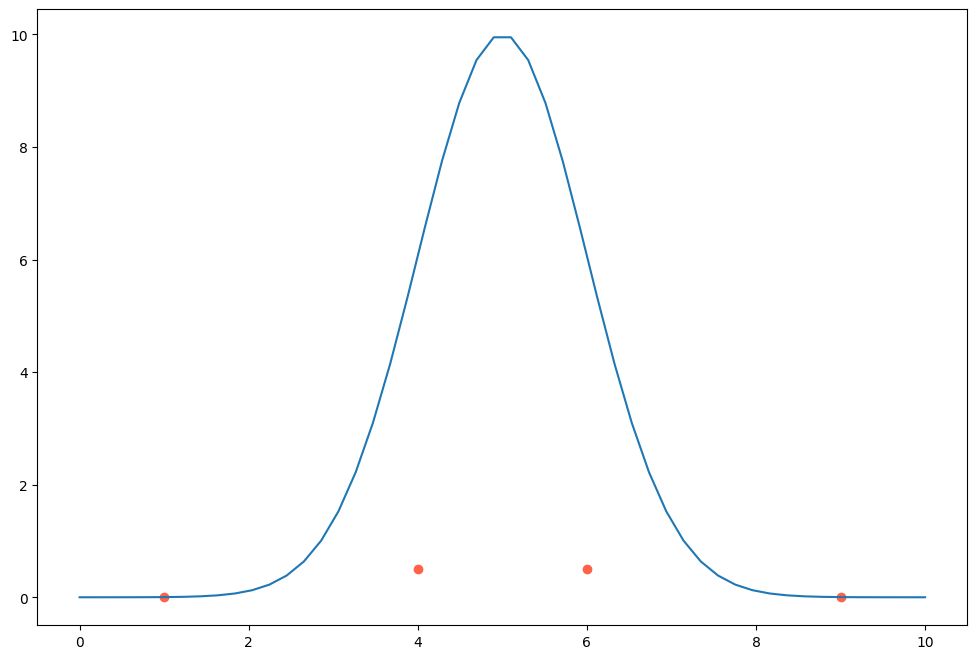

In [10]:
def gaussian(x, peak, sigma, height):
    return height*np.exp(-np.power(x - peak, 2.) / (2 * np.power(sigma, 2.)))

plt.figure()
xx=linspace(0,10)
sigma=1
peak=5
plt.plot(xx,gaussian(xx,peak,sigma,10))
plt.scatter(4,0.5,color='tomato')
plt.scatter(6,0.5,color='tomato')

plt.scatter(peak-4*sigma,0.,color='tomato')
plt.scatter(peak+4*sigma,0.,color='tomato')

C:\Users\clara\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


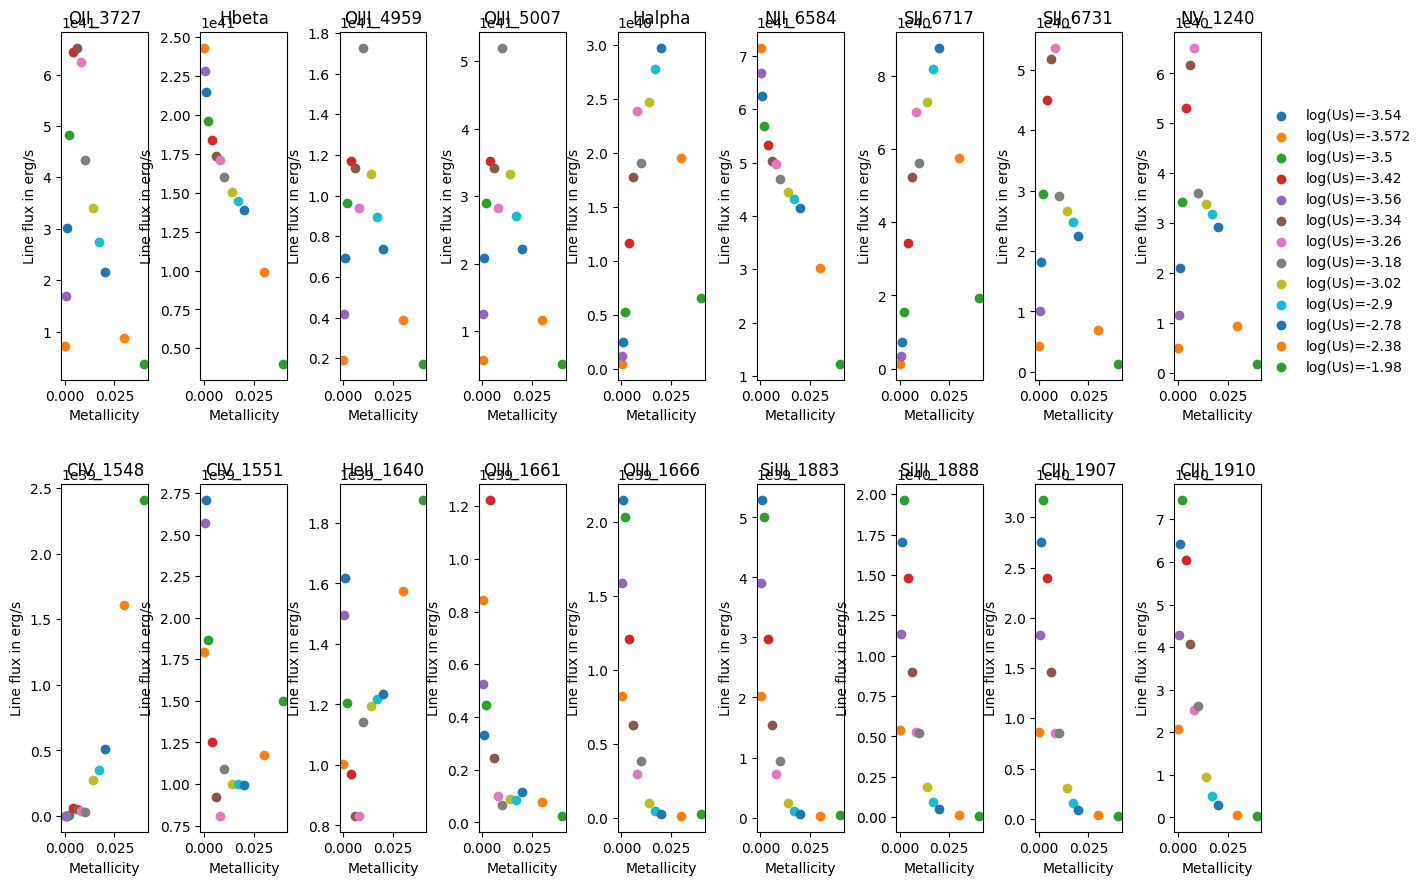

In [11]:

Zcode_dic = ['Z001','Z0002','Z002','Z004','Z0005','Z006','Z008','Z010','Z014','Z017','Z020','Z030','Z040']

Zcode_met = [0.001, 0.0002, 0.002, 0.004, 0.0005, 0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03, 0.04]

x_id = 0.1
n_h = 1000
sfr = 1.5
rate = 1.00
muv = 100

import matplotlib as mtp
mtp.rcParams['figure.figsize']=[30,20]
fig=plt.figure()
gs1=gridspec.GridSpec(2,9)
gs1.update(left=0.1,right=0.5, bottom=0.2, top=0.6, hspace=0.3, wspace=0.6)


for ff in range(len(Zcode_dic)):
    #print(ff)
    log_Us = 0.8*float(Zcode_met[ff]/0.02)-3.58
    logUs, xid, nh, rat, m_UV, line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910 =np.loadtxt('Emission_lines/nebular_emission_'+str(Zcode_dic[ff])+'.txt',skiprows=1,unpack=True)
    line_name=np.array([line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910])
    line_wavelength=[3727,4861,4959,5007,6563,6584,6717,6731,1240,1548,1551,1640,1661,1666,1883,1888,1907,1910]
    line_title=np.array(['OII_3727', 'Hbeta', 'OIII_4959', 'OIII_5007', 'Halpha', 'NII_6584', 'SII_6717', 'SII_6731', 'NV_1240',
                         'CIV_1548', 'CIV_1551', 'HeII_1640', 'OIII_1661', 'OIII_1666', 'SiIII_1883', 'SiIII_1888', 'CIII_1907', 'CIII_1910'])

    #line_wavelength=[pp*0.0001*(1+z) for pp in line_wavelength]

    ### FIX WITH PROPER FLUX AND SELECT LINE!!!!
    #line_flux=[1e44]*len(line_wavelength) #[lne_name[pp][0]*1e47/1e45 for pp in range(len(line_wavelength))] # the amplitude of the line, to be taken from Gutkin+16
    for ss in range(len(logUs)):
        if logUs[ss] == round(log_Us*2)/2 and xid[ss] == x_id and nh[ss] == n_h and m_UV[ss]==muv and rat[ss]==rate:
            line_flux=[line_name[pp][ss]*3.826e+33*sfr for pp in range(len(line_wavelength))] 
            #print(line_flux)
            for xx in range(len(line_flux)):
                #print(line_flux[xx])
                ax = plt.subplot(gs1[xx])
                ax.scatter(np.float(Zcode_met[ff]), np.float(line_flux[xx]),label='log(Us)='+str(np.round(log_Us,3)))
                ax.set_title(str(line_title[xx]))
                if xx == 8:
                    ax.legend(frameon=False,loc=(1,0))
                ax.set_ylabel('Line flux in erg/s')
                ax.set_xlabel('Metallicity')
                #print(xx)
#fig.tight_layout()
fig.savefig('Figures/line_flux_var_metallicity.png')


C:\Users\clara\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


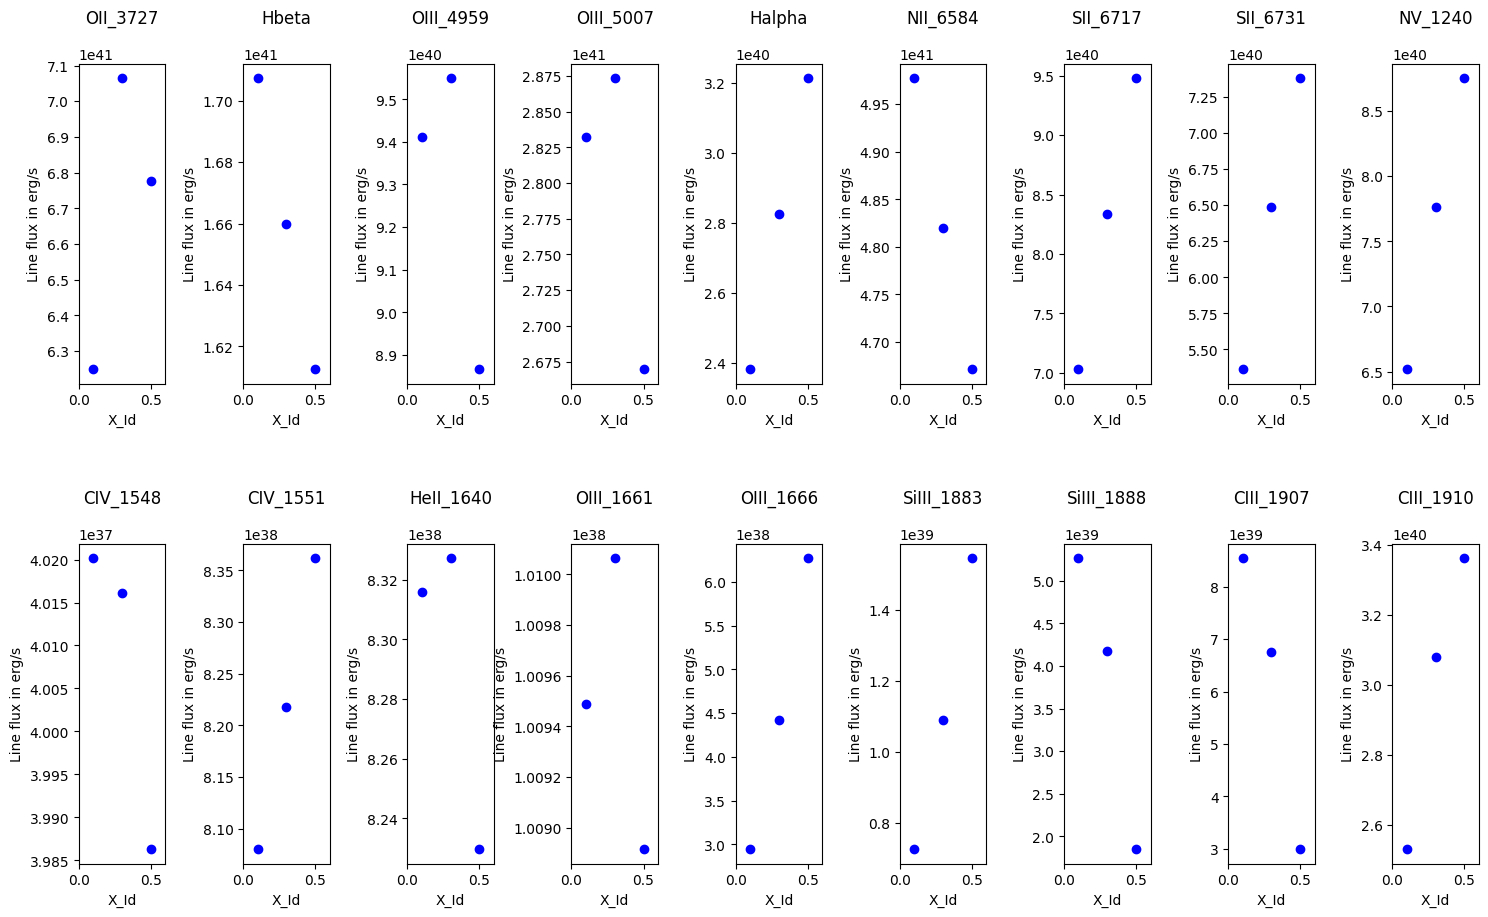

In [23]:

Zcode_dic = ['Z001','Z0002','Z002','Z004','Z0005','Z006','Z008','Z010','Z014','Z017','Z020','Z030','Z040']

Zcode_met = [0.001, 0.0002, 0.002, 0.004, 0.0005, 0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03, 0.04]

x_id = [0.1,0.3,0.5]
n_h = 1000
sfr = 1.5
rate = 1.00
muv = 100

import matplotlib as mtp
mtp.rcParams['figure.figsize']=[35,20]
fig=plt.figure()
gs1=gridspec.GridSpec(2,9)
gs1.update(left=0.1,right=0.5, bottom=0.2, top=0.6, hspace=0.5, wspace=0.9)

log_Us = 0.8*float(Zcode_met[ff])-3.58
logUs, xid, nh, rat, m_UV, line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910 =np.loadtxt('Emission_lines/nebular_emission_Z008.txt',skiprows=1,unpack=True)
line_name=np.array([line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910])
line_wavelength=[3727,4861,4959,5007,6563,6584,6717,6731,1240,1548,1551,1640,1661,1666,1883,1888,1907,1910]
line_title=np.array(['OII_3727', 'Hbeta', 'OIII_4959', 'OIII_5007', 'Halpha', 'NII_6584', 'SII_6717', 'SII_6731', 'NV_1240',
                        'CIV_1548', 'CIV_1551', 'HeII_1640', 'OIII_1661', 'OIII_1666', 'SiIII_1883', 'SiIII_1888', 'CIII_1907', 'CIII_1910'])

#line_wavelength=[pp*0.0001*(1+z) for pp in line_wavelength]

### FIX WITH PROPER FLUX AND SELECT LINE!!!!
#line_flux=[1e44]*len(line_wavelength) #[lne_name[pp][0]*1e47/1e45 for pp in range(len(line_wavelength))] # the amplitude of the line, to be taken from Gutkin+16
for ll in x_id:
    for ss in range(len(logUs)):
        if logUs[ss] == round(log_Us*2)/2 and xid[ss] == ll and nh[ss] == n_h and m_UV[ss]==muv and rat[ss]==rate:
            line_flux=[line_name[pp][ss]*3.826e+33*sfr for pp in range(len(line_wavelength))] 
            #print(line_flux)
            for xx in range(len(line_flux)):
                #print(line_flux[xx])
                ax = plt.subplot(gs1[xx])
                ax.scatter(np.float(ll), np.float(line_flux[xx]),color ='blue')
                ax.set_title(str(line_title[xx]),x=0.5,y=1.1)
                ax.set_ylabel('Line flux in erg/s')
                ax.set_xlabel('X_Id')
                ax.set_xlim(0,0.6)
                #print(xx)
#fig.tight_layout()
fig.savefig('Figures/line_flux_var_xID.png')


C:\Users\clara\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


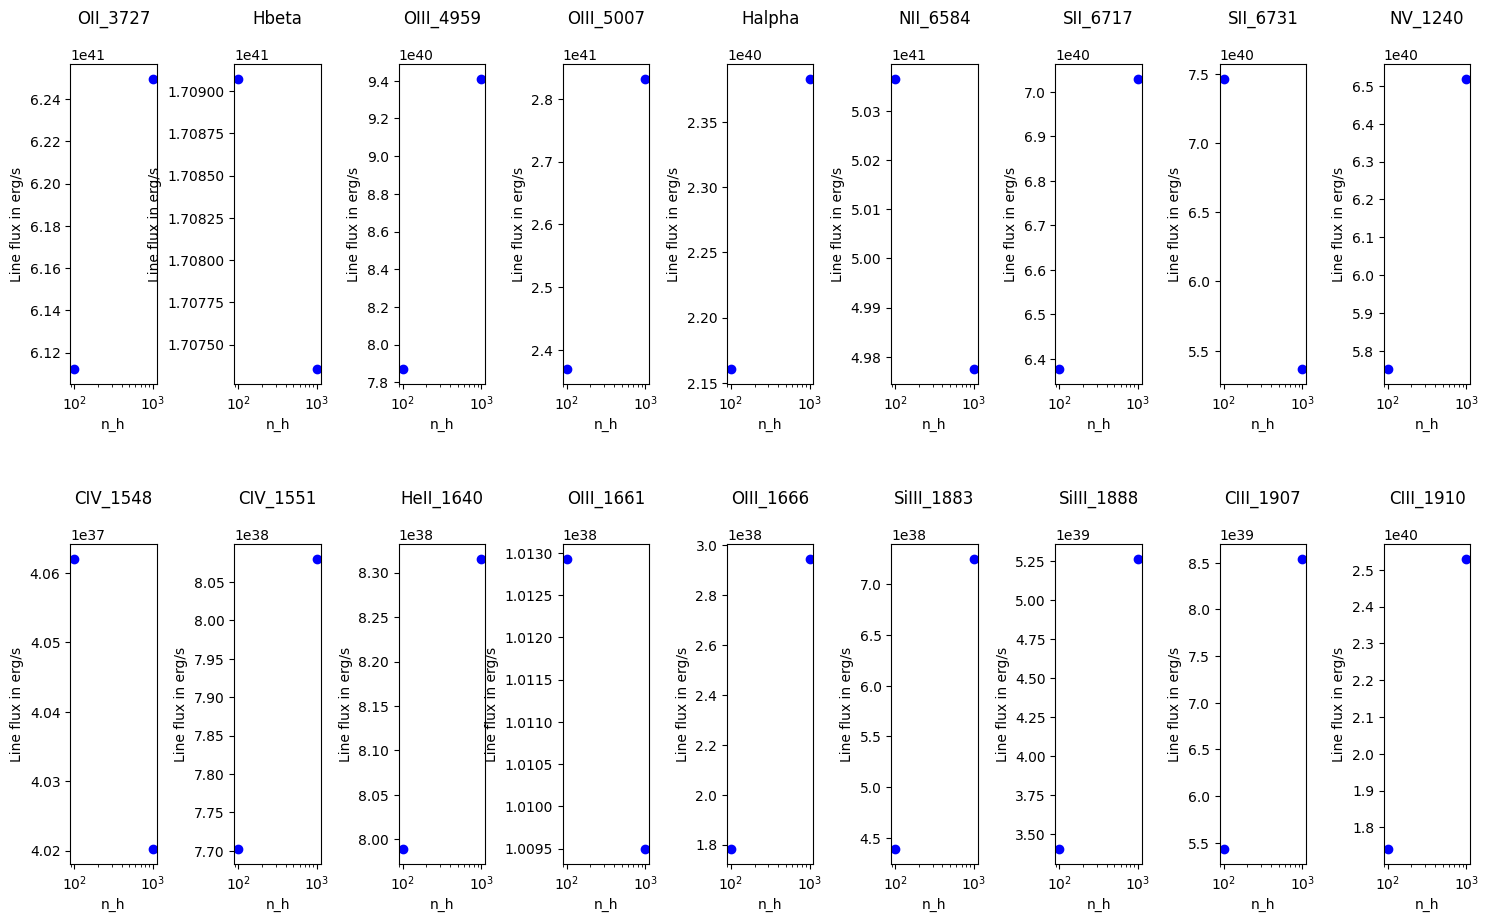

In [29]:

Zcode_dic = ['Z001','Z0002','Z002','Z004','Z0005','Z006','Z008','Z010','Z014','Z017','Z020','Z030','Z040']

Zcode_met = [0.001, 0.0002, 0.002, 0.004, 0.0005, 0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03, 0.04]

x_id = 0.1
n_h = [100,1000]
sfr = 1.5
rate = 1.00
muv = 100

import matplotlib as mtp
mtp.rcParams['figure.figsize']=[35,20]
fig=plt.figure()
gs1=gridspec.GridSpec(2,9)
gs1.update(left=0.1,right=0.5, bottom=0.2, top=0.6, hspace=0.5, wspace=0.9)

log_Us = 0.8*float(Zcode_met[ff])-3.58
logUs, xid, nh, rat, m_UV, line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910 =np.loadtxt('Emission_lines/nebular_emission_Z008.txt',skiprows=1,unpack=True)
line_name=np.array([line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910])
line_wavelength=[3727,4861,4959,5007,6563,6584,6717,6731,1240,1548,1551,1640,1661,1666,1883,1888,1907,1910]
line_title=np.array(['OII_3727', 'Hbeta', 'OIII_4959', 'OIII_5007', 'Halpha', 'NII_6584', 'SII_6717', 'SII_6731', 'NV_1240',
                        'CIV_1548', 'CIV_1551', 'HeII_1640', 'OIII_1661', 'OIII_1666', 'SiIII_1883', 'SiIII_1888', 'CIII_1907', 'CIII_1910'])

#line_wavelength=[pp*0.0001*(1+z) for pp in line_wavelength]

### FIX WITH PROPER FLUX AND SELECT LINE!!!!
#line_flux=[1e44]*len(line_wavelength) #[lne_name[pp][0]*1e47/1e45 for pp in range(len(line_wavelength))] # the amplitude of the line, to be taken from Gutkin+16
for ll in n_h:
    for ss in range(len(logUs)):
        if logUs[ss] == round(log_Us*2)/2 and xid[ss] == x_id and nh[ss] == ll and m_UV[ss]==muv and rat[ss]==rate:
            line_flux=[line_name[pp][ss]*3.826e+33*sfr for pp in range(len(line_wavelength))] 
            #print(line_flux)
            for xx in range(len(line_flux)):
                #print(line_flux[xx])
                ax = plt.subplot(gs1[xx])
                ax.scatter(np.float(ll), np.float(line_flux[xx]),color ='blue')
                ax.set_title(str(line_title[xx]),x=0.5,y=1.1)
                ax.set_ylabel('Line flux in erg/s')
                ax.set_xlabel('n_h')
                ax.set_xscale('log')
                #ax.set_xlim(0,0.6)
                #print(xx)
#fig.tight_layout()
fig.savefig('Figures/line_flux_var_nh.png')


C:\Users\clara\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


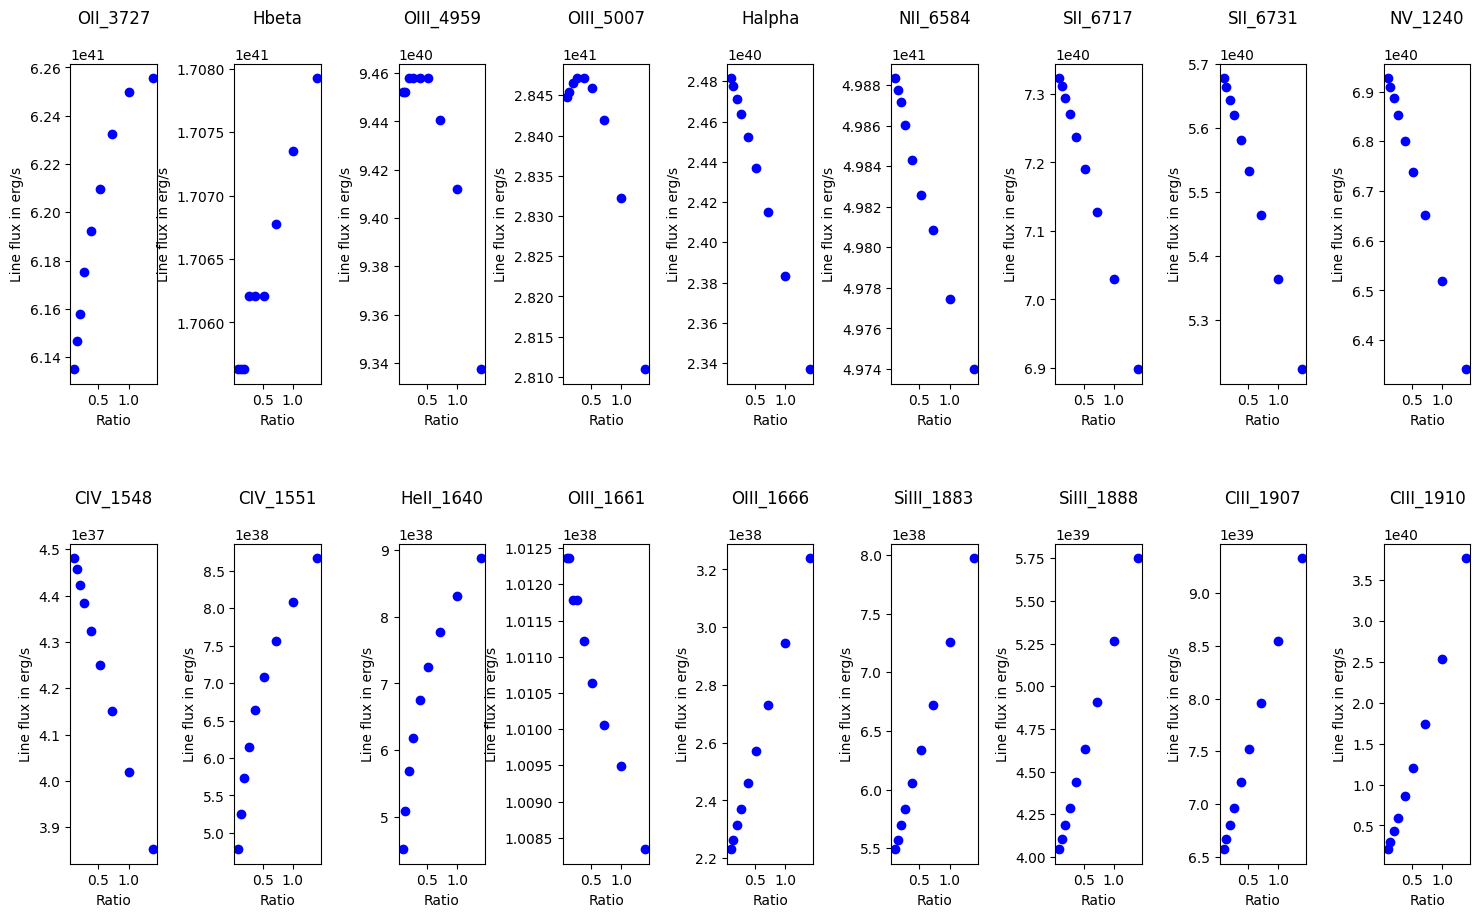

In [3]:

Zcode_dic = ['Z001','Z0002','Z002','Z004','Z0005','Z006','Z008','Z010','Z014','Z017','Z020','Z030','Z040']

Zcode_met = [0.001, 0.0002, 0.002, 0.004, 0.0005, 0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03, 0.04]

x_id = 0.1
n_h = 1000
sfr = 1.5
rate = [1.40,1.00,0.72,0.52,0.38,0.27,0.20,0.14,0.10]
muv = 100

import matplotlib as mtp
mtp.rcParams['figure.figsize']=[35,20]
fig=plt.figure()
gs1=gridspec.GridSpec(2,9)
gs1.update(left=0.1,right=0.5, bottom=0.2, top=0.6, hspace=0.5, wspace=0.9)

log_Us = 0.8*float(0.008)-3.58
logUs, xid, nh, rat, m_UV, line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910 =np.loadtxt('Emission_lines/nebular_emission_Z008.txt',skiprows=1,unpack=True)
line_name=np.array([line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910])
line_wavelength=[3727,4861,4959,5007,6563,6584,6717,6731,1240,1548,1551,1640,1661,1666,1883,1888,1907,1910]
line_title=np.array(['OII_3727', 'Hbeta', 'OIII_4959', 'OIII_5007', 'Halpha', 'NII_6584', 'SII_6717', 'SII_6731', 'NV_1240',
                        'CIV_1548', 'CIV_1551', 'HeII_1640', 'OIII_1661', 'OIII_1666', 'SiIII_1883', 'SiIII_1888', 'CIII_1907', 'CIII_1910'])

#line_wavelength=[pp*0.0001*(1+z) for pp in line_wavelength]

### FIX WITH PROPER FLUX AND SELECT LINE!!!!
#line_flux=[1e44]*len(line_wavelength) #[lne_name[pp][0]*1e47/1e45 for pp in range(len(line_wavelength))] # the amplitude of the line, to be taken from Gutkin+16
for ll in rate:
    for ss in range(len(logUs)):
        if logUs[ss] == round(log_Us*2)/2 and xid[ss] == x_id and nh[ss] == n_h and m_UV[ss]==muv and rat[ss]==ll:
            line_flux=[line_name[pp][ss]*3.826e+33*sfr for pp in range(len(line_wavelength))] 
            #print(line_flux)
            for xx in range(len(line_flux)):
                #print(line_flux[xx])
                ax = plt.subplot(gs1[xx])
                ax.scatter(np.float(ll), np.float(line_flux[xx]),color ='blue')
                ax.set_title(str(line_title[xx]),x=0.5,y=1.1)
                ax.set_ylabel('Line flux in erg/s')
                ax.set_xlabel('Ratio')
                #ax.set_xscale('log')
                #ax.set_xlim(0,0.6)
                #print(xx)
#fig.tight_layout()
fig.savefig('Figures/line_flux_var_rate.png')


C:\Users\clara\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


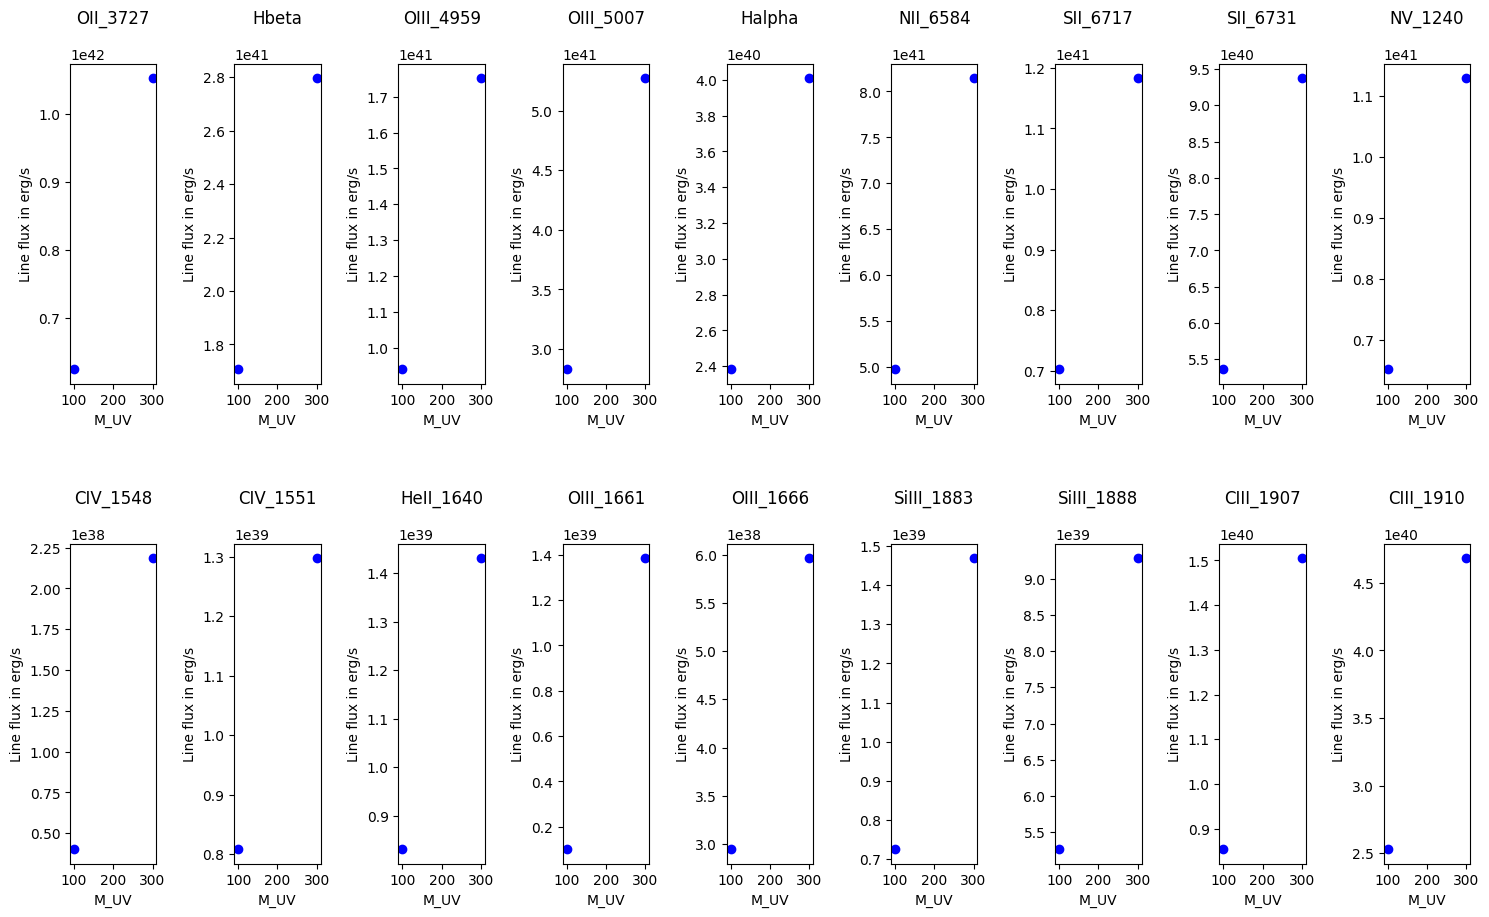

In [7]:

Zcode_dic = ['Z001','Z0002','Z002','Z004','Z0005','Z006','Z008','Z010','Z014','Z017','Z020','Z030','Z040']

Zcode_met = [0.001, 0.0002, 0.002, 0.004, 0.0005, 0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03, 0.04]

x_id = 0.1
n_h = 1000
sfr = 1.5
rate = 1.00
muv = [100,300]

import matplotlib as mtp
mtp.rcParams['figure.figsize']=[35,20]
fig=plt.figure()
gs1=gridspec.GridSpec(2,9)
gs1.update(left=0.1,right=0.5, bottom=0.2, top=0.6, hspace=0.5, wspace=0.9)

log_Us = 0.8*float(0.008)-3.58
logUs, xid, nh, rat, m_UV, line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910 =np.loadtxt('Emission_lines/nebular_emission_Z008.txt',skiprows=1,unpack=True)
line_name=np.array([line_OII_3727, line_Hbeta, line_OIII_4959, line_OIII_5007, line_Halpha, line_NII_6584, line_SII_6717, line_SII_6731, line_NV_1240, line_CIV_1548, line_CIV_1551, line_HeII_1640, line_OIII_1661, line_OIII_1666, line_SiIII_1883, line_SiIII_1888, line_CIII_1907, line_CIII_1910])
line_wavelength=[3727,4861,4959,5007,6563,6584,6717,6731,1240,1548,1551,1640,1661,1666,1883,1888,1907,1910]
line_title=np.array(['OII_3727', 'Hbeta', 'OIII_4959', 'OIII_5007', 'Halpha', 'NII_6584', 'SII_6717', 'SII_6731', 'NV_1240',
                        'CIV_1548', 'CIV_1551', 'HeII_1640', 'OIII_1661', 'OIII_1666', 'SiIII_1883', 'SiIII_1888', 'CIII_1907', 'CIII_1910'])

#line_wavelength=[pp*0.0001*(1+z) for pp in line_wavelength]

### FIX WITH PROPER FLUX AND SELECT LINE!!!!
#line_flux=[1e44]*len(line_wavelength) #[lne_name[pp][0]*1e47/1e45 for pp in range(len(line_wavelength))] # the amplitude of the line, to be taken from Gutkin+16
for ll in muv:
    for ss in range(len(logUs)):
        if logUs[ss] == round(log_Us*2)/2 and xid[ss] == x_id and nh[ss] == n_h and m_UV[ss]==ll and rat[ss]==rate:
            line_flux=[line_name[pp][ss]*3.826e+33*sfr for pp in range(len(line_wavelength))] 
            #print(line_flux)
            for xx in range(len(line_flux)):
                #print(line_flux[xx])
                ax = plt.subplot(gs1[xx])
                ax.scatter(np.float(ll), np.float(line_flux[xx]),color ='blue')
                ax.set_title(str(line_title[xx]),x=0.5,y=1.1)
                ax.set_ylabel('Line flux in erg/s')
                ax.set_xlabel('M_UV')
                #ax.set_xscale('log')
                #ax.set_xlim(0,0.6)
                #print(xx)
#fig.tight_layout()
fig.savefig('Figures/line_flux_var_muv.png')
